# A Sketch of How to Approximate Wasserstein between Persistence Diagrams

The goal is to compute an approximation of Wasserstein distance between pairs of persistence diagrams via a soft-binning strategy of Gaussian mixture models and then using Earth Mover Distance to compute the approximate Wasserstein distance.

This notebook is in two parts - the first part is a walk-through explaining how the approximation works. All of this functionality is capured in the pervect.py file.  The second part we will just import the libraries directly from the file and explore convergence results, parameters, and performance. 


We'll need a few libraries -- the expected ones, plus [ot](https://pot.readthedocs.io/en/stable/index.html) which computes optimal transport plans with efficient Cython code, and [umap](https://umap-learn.readthedocs.io/en/latest/) so we can visualize the results easily.

In [1]:
import numpy as np
import scipy.linalg
import scipy.stats
import sklearn.metrics
from sklearn.cluster import KMeans
import numba
import matplotlib.pyplot as plt
import ot
import umap
import seaborn as sns

sns.set(style='white')

/opt/anaconda3/envs/tda/lib/python3.7/site-packages/pynndescent/sparse.py:420: NumbaTypeSafetyWarning: unsafe cast from uint32 to int32. Precision may be lost.
  _, aux_data = sparse_mul(ind1, data1, ind2, data2)


## Adding more example diagrams


Teaspoon is a package for doing various TDA stuff. Code is [here](https://github.com/lizliz/teaspoon).  Someday it will be set up to do pip install.  Today is not that day.

In [2]:
from teaspoon.MakeData.PointCloud import testSetManifolds 
from teaspoon.TDA.Distance import dgmDist_Hera

Were are going to generate 100 small examples from each of the 6 classes

In [3]:
%%time
manifoldData = testSetManifolds(numDgms = 100, numPts = 300, permute = False, seed = 0)

Generating torus clouds...
Generating annuli clouds...
Generating cube clouds...
Generating three cluster clouds...
Generating three clusters of three clusters clouds...
Generating sphere clouds...
Finished generating clouds and computing persistence.

CPU times: user 4min 36s, sys: 23.9 s, total: 5min
Wall time: 1min 23s


In [4]:
# We are just going to consider the 1-dimension persistence 

# In birth-death
JustDgms_death = list(manifoldData['Dgm1'])
# In birth-lifetime
JustDgms_lifetime = [np.concatenate([[X[:,0]],[X[:,1]-X[:,0]]], axis = 0).T for X in JustDgms_death]

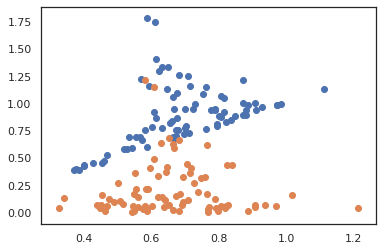

In [5]:
# Some typical examples to look at
example = JustDgms_death[0]
example2 = JustDgms_lifetime[1]
plt.scatter(*example.T)
plt.scatter(*example2.T)

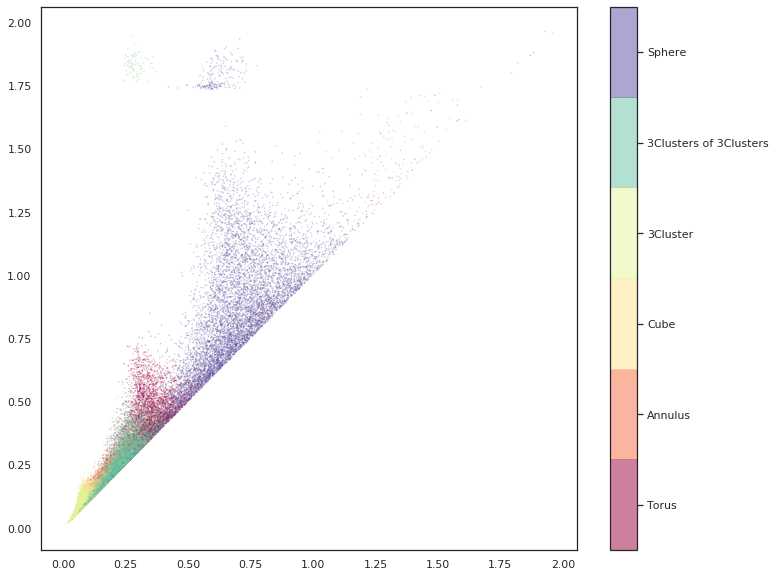

In [6]:
# Here's the complete data for all of the Dgms (with y_axis = 'death')

combined_data = np.vstack(JustDgms_death)
labels = np.hstack([np.full(len(JustDgms_death[i]), i//100) for i in range(len(JustDgms_death))])
plt.figure(figsize=(12,10))
plt.scatter(*combined_data[::-1].T, s=0.1, c=labels, cmap='Spectral', alpha=0.5)
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(manifoldData.trainingLabel.unique())

In [7]:
def wasserstein_diagram_distance(p, pts0, pts1, y_axis='death'):
    '''
    Compute the Persistant p-Wasserstein distance between the diagrams pts0, pts1
    
    y_axis = 'death' (default), or 'lifetime'
    
    '''
    
    if y_axis == 'lifetime':
        extra_dist0 = pts0[:, 1]
        extra_dist1 = pts1[:, 1]
    elif y_axis == 'death':    
        extra_dist0 = (pts0[:, 1]-pts0[:, 0])/np.sqrt(2)
        extra_dist1 = (pts1[:, 1]-pts1[:, 0])/np.sqrt(2)
    else:
        raise ValueError('y_axis must be \'death\' or \'lifetime\'')
        
    pairwise_dist = sklearn.metrics.pairwise_distances(pts0, pts1)
    
    all_pairs_ground_distance_a = np.hstack([pairwise_dist, extra_dist0[:, np.newaxis]])
    extra_row = np.zeros(all_pairs_ground_distance_a.shape[1])
    extra_row[:pairwise_dist.shape[1]] = extra_dist1
    all_pairs_ground_distance_a = np.vstack([all_pairs_ground_distance_a, extra_row])
  
    all_pairs_ground_distance_a = all_pairs_ground_distance_a**p
    
    n0 = pts0.shape[0]
    n1 = pts1.shape[0]
    a = np.ones(n0+1)
    a[n0]=n1
    a = a/a.sum()
    b = np.ones(n1+1)
    b[n1]=n0
    b = b/b.sum()
    
    return np.power((n0+n1)*ot.emd2(a, b, all_pairs_ground_distance_a),1.0/p)


## Computing Persistent Wasserstein distances for benchmarking and comparison

We'll compute W_1 (y_axis = death) and W_2 (y_axis = lifetime) just for an example and primarily use W_1 (y_axis = death) for the rest of the walk-through

In [8]:
%%time
wass_all_pairs_dist = np.zeros((600,600))
for i in range(600):
    for j in range(i,600):
        wass_all_pairs_dist[i,j] = wasserstein_diagram_distance(1,
                                            JustDgms_death[i], JustDgms_death[j], y_axis='death')
        wass_all_pairs_dist[j,i] = wass_all_pairs_dist[i,j]
    

CPU times: user 3min 55s, sys: 4.57 s, total: 3min 59s
Wall time: 3min 21s


In [9]:
%%time
wass2_all_pairs_dist = np.zeros((600,600))
for i in range(600):
    for j in range(i,600):
        wass2_all_pairs_dist[i,j] = wasserstein_diagram_distance(2, 
                                            JustDgms_lifetime[i], JustDgms_lifetime[j], y_axis='lifetime')
        wass2_all_pairs_dist[j,i] = wass2_all_pairs_dist[i,j]

CPU times: user 4min, sys: 4.37 s, total: 4min 4s
Wall time: 3min 27s


Lets take a quick comparison between the W_1 (y_axis = death) and W_2 (y_axis = lifetime) to show that while they are strongly correlated, they are indeed different.  Clearly there are lots of choices (these being just two) and it's not obvious that there is a 'right' one. 

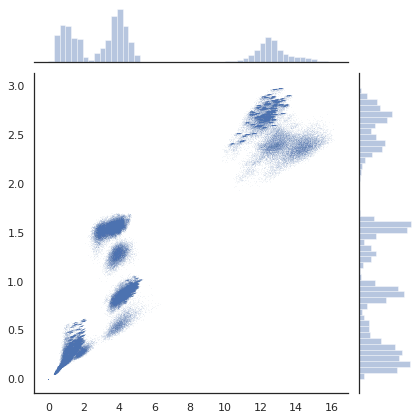

In [10]:
sns.jointplot(wass_all_pairs_dist.flatten(), wass2_all_pairs_dist.flatten(), joint_kws={'s':0.01, 'alpha':0.1})

In [11]:
scipy.stats.pearsonr(wass_all_pairs_dist.flatten(), wass2_all_pairs_dist.flatten())

(0.9240281186393156, 0.0)

## Gaussian mixture modelling

The next step is construct the Gaussian mixture model to be used for soft-binning. We want to construct this over the union of all the diagrams to find the globally optimal binning strategy, so we'll just vstack them together (which we already did above for visualization).

In [12]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize

Running the model on all the data is pretty fast. We went with 10 components because that "seemed like enough", but there is plenty of scope for better parameter selection. Note that as the number of components tends to infinity this algorithm will tend towards diracs at each datapoint (not technically achievable via the EM optimization, but theoretically that is the correct MLE). It is also worth noting that sklearn's GMM initializes via k-means by default, so we are improving on a k-means binning immediately.

In [13]:
N_bins = 10

In [14]:
%%time
gmm  = GaussianMixture(n_components=N_bins).fit(combined_data)

CPU times: user 7.16 s, sys: 638 ms, total: 7.79 s
Wall time: 2.11 s


Just for curiousity lets see where the centers of the Gaussians end up

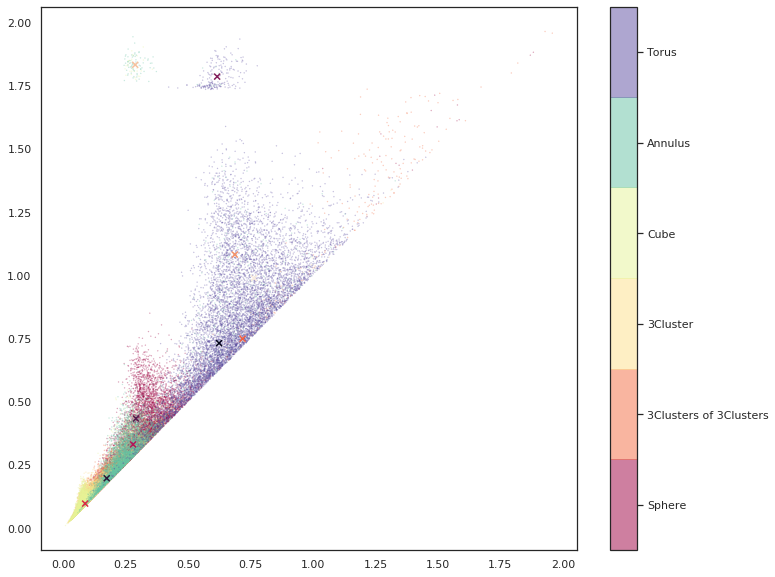

In [15]:
plt.figure(figsize=(12,10))
labels = np.hstack([np.full(len(JustDgms_death[i]), i//100) for i in range(len(JustDgms_death))])
plt.scatter(*combined_data[::-1].T, s=0.1, c=labels, cmap='Spectral', alpha=0.5)
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(manifoldData.trainingLabel.unique()[::-1])
plt.scatter(*gmm.means_.T, marker="x", c=np.arange(N_bins))

## Soft Binning

For each diagram we just need to determine the sum of likelihoods of all the data under each gaussian mixture component.  

In [16]:
def gmm_component_likelihood(component_mean, component_covar, diagram):
    return scipy.stats.multivariate_normal.pdf(
        diagram,
        mean=component_mean,
        cov=component_covar,
    )

And now we can "vectorize" a diagram by writing the vector of soft-binned values. Essentially each point in the diagram has a total weight of one to contribute and we spread that weight across the components according to the relative likelihoods of observing that point under each component. In practical terms we just get the vector of likelihoods for all the points for each component and then normalize so each column (the vector of likelihoods of being observed by a component for a given point) sums to one; the resulting vectorization is simply the sum over all the points -- i.e. the vector of row sums.

In [17]:
def vectorize_diagram(diagram, gmm):
    interim_matrix = np.zeros((gmm.n_components, diagram.shape[0]))
    for i in range(interim_matrix.shape[0]):
        interim_matrix[i] = gmm_component_likelihood(
            gmm.means_[i], gmm.covariances_[i], diagram
        )
    normalize(interim_matrix, norm='l1', axis=0, copy=False)
    return interim_matrix.sum(axis=1)

Now we vectorize the model data set

In [18]:
%%time
vectorized_data = np.vstack([
    vectorize_diagram(diagram, gmm) for diagram in JustDgms_death
])

CPU times: user 1.14 s, sys: 3.12 ms, total: 1.14 s
Wall time: 1.14 s


Just as a sanity check, lets just embed the diagrams with umap using hellinger distance (i.e. we will just treat each vector as a multinomial of the weights assigned to each Gaussian)

In [19]:
mapper = umap.UMAP(metric='hellinger').fit(vectorized_data)

/opt/anaconda3/envs/tda/lib/python3.7/site-packages/umap/spectral.py:243: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


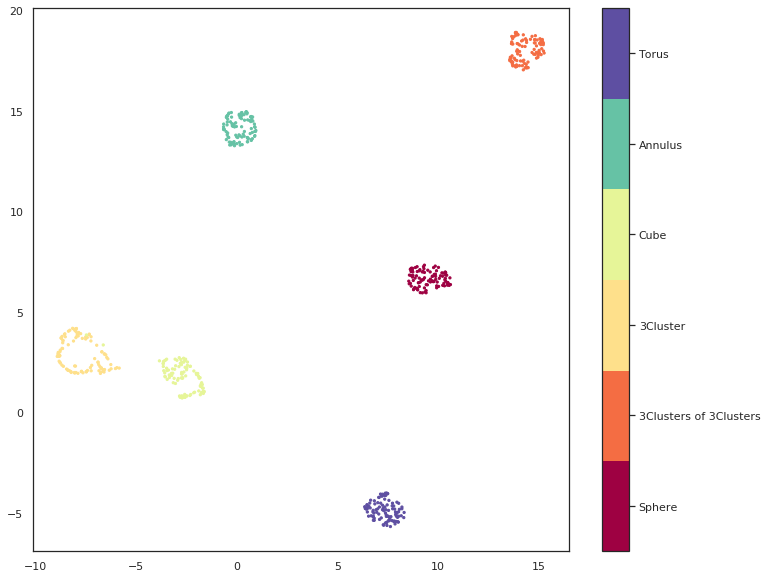

In [20]:
plt.figure(figsize=(12,10))
labels = np.concatenate([i * np.ones(100) for i in range(6)])
plt.scatter(*mapper.embedding_.T, s=5, c=labels, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(manifoldData.trainingLabel.unique()[::-1])


This isn't too surprising that this does so well.  Thinking of approximating diagrams with Gaussian mixture models, we are just computing the distance between the multinomial mixing parameters (essentially treating each Gaussian as a categorical).  This should be a coarse approximation to Wasserstein as all it fails to take into account completely is the ground distance, and the umap embedding bears this out.  

## Computing ground distances

We need to compute pairwise distances between each gaussian, which we can do with a closed form formula:
$$W_{2} (\mu_1, \mu_2)^2 = \| m_1 - m_2 \|_2^2 + \mathop{\mathrm{trace}} \bigl( C_1 + C_2 - 2 \bigl( C_2^{1/2} C_1 C_2^{1/2} \bigr)^{1/2} \bigr)$$

Note that as the covariance shrinks (which is will as more components are added) and the Gaussians tend to Diracs, then this simplifies to just euclidean distance. In other words in the limit we will have euclidean ground distance, and each "bin" will contain exactly one point, so we are "clearly" tending toward computing true Wasserstein distance as we increase the number of bins towards the total number of points in all the diagrams. 

In [21]:
@numba.njit()
def mat_sqrt(mat):
    rt = mat.copy()
    s = mat[0,0]*mat[1,1] - mat[1,0]*mat[0,1]
    factor = 1.0/(mat[0,0] + mat [1,1] + 2.0*s)
    rt[0,0]=rt[0,0]*np.sqrt(factor) + np.sqrt(s*factor)
    rt[1,1]=rt[1,1]*np.sqrt(factor) + np.sqrt(s*factor)
    rt[0,1]*=np.sqrt(factor)
    rt[1,0]*=np.sqrt(factor)
    return rt

@numba.njit()
def numba_wasserstein2_normal(m1, C1, m2, C2):    
    result = np.sum((m1 - m2)**2)
    sqrt_C2 = mat_sqrt(C2)
    prod_matrix = sqrt_C2 @ C1 @ sqrt_C2
    sqrt_prod_matrix = mat_sqrt(prod_matrix)
    correction_matrix = C1 + C2 - 2 * sqrt_prod_matrix
    result += correction_matrix[0,0] + correction_matrix[1,1]
    return np.sqrt(np.maximum(result, 0))

The ground distance for the Earth Mover distance computation is just the all pairs of the above. This is efficient to compute since we have only a small number of bins.

In [22]:
%%time
all_pairs_ground_distance = np.array([
    [
        numba_wasserstein2_normal(gmm.means_[i], gmm.covariances_[i], 
                            gmm.means_[j], gmm.covariances_[j])
        for j in range(gmm.n_components)
    ]
    for i in range(gmm.n_components)
])

CPU times: user 1.02 s, sys: 2.99 ms, total: 1.03 s
Wall time: 1.06 s


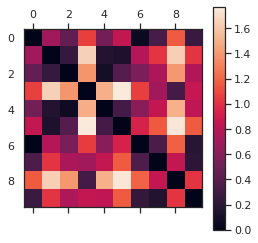

In [23]:
im = plt.matshow(all_pairs_ground_distance)
plt.colorbar(im)

This is actually a good demonstration of why the ground distance matters. 

## Persistent Wasserstein

We are just grabbing an optimal transport library to do the work of computing things -- the catch is that it expects the histograms to be normalized (i.e. on a simplex).  This is no big deal because we append the sum of each vector to the opposite in the place of the special bin (the lifetime=0 bin) and so our two histograms will have equal weight (the sum of the two original vectors).  Hence we can just compute the optimal trasport of the normalization and then just rescale afterwards.  

First we add the extra bin distance to the cost matrix.  The distance from a Gaussian to lifetime=0 is the Euclidean distance from the mean to lifetime=0 together with the extra term for the covariance.  The extra term comes from the fact that the cost to move along the lifetime=0 line is 0 and so we only need to 'move' the mass of the Gaussian to be 1-dimensional.  The work to do this is the same an contracting the 1-d Gaussian orthogonal to the lifetime=0 line to a dirac which (if you look it up in 'A Class of Wasserstein Metrics For Probability Distributions by Riley, Shortt (1984)') is just the square root of the variance. 

In [24]:
def add_birth_death_line(ground_distance, means, covariances, y_axis='death'):
    '''
    Return an appended ground distance matrix with the extra distance to the lifetime=0 line 
    '''
    
    if y_axis == 'lifetime':
        euclidean_dist = means[:, 1]
        anti_line = np.array([0,1])
    elif y_axis == 'death':    
        euclidean_dist = (means[:, 1]-means[:, 0])/np.sqrt(2)
        anti_line = 1/np.sqrt(2)*np.array([1,-1])
    else:
        raise ValueError('y_axis must be \'death\' or \'lifetime\'')
    
    variances = anti_line@covariances@anti_line.T     
    extra_dist = euclidean_dist + np.sqrt(variances)
    ground_distance_a = np.hstack([ground_distance, extra_dist[:, np.newaxis]])
    extra_row = np.zeros(ground_distance_a.shape[1])
    extra_row[:ground_distance.shape[1]] = extra_dist
    ground_distance_a = np.vstack([ground_distance_a, extra_row])
    return ground_distance_a
    

In [25]:
all_pairs_ground_distance_a = add_birth_death_line(all_pairs_ground_distance, gmm.means_, gmm.covariances_)

So now we can compute a wasserstein distance between vectorized diagrams using the ground distance between bins we computed earlier, with the modification of adding the total weight of x to y's extra bin and visa versa.

In [26]:
def per_wass_dist_vectorized(x, y, ground_distance=all_pairs_ground_distance_a):
    x_a = np.append(x, y.sum())
    x_a/= x_a.sum()
    y_a = np.append(y, x.sum())
    y_a/= y_a.sum()
    wass = ot.emd2(x_a, y_a, ground_distance)
    return (x.sum()+y.sum())*wass

Finally it is a simple matter to compute all the pairwise distance between all 600 diagrams.

In [27]:
%%time
p=1
all_pairs_distances_a = sklearn.metrics.pairwise_distances(
    vectorized_data, 
    metric=per_wass_dist_vectorized,
    n_jobs=-1,
    ground_distance=all_pairs_ground_distance_a**p,
)
all_pairs_distances_a = np.power(all_pairs_distances_a, 1.0/p)

CPU times: user 39.8 s, sys: 11.9 s, total: 51.7 s
Wall time: 45.1 s


## UMAP the distance matrix

Since we have an all pairs distance matrix we can actually hand that to UMAP to find a 2-dimensional representation of the space of these persistence diagrams (under the approximated Wasserstein distance). In an ideal world this would manage to seprate out the two different classes of diagrams that we generated.

In [28]:
%%time
mapper = umap.UMAP(metric="precomputed").fit(all_pairs_distances_a)

/opt/anaconda3/envs/tda/lib/python3.7/site-packages/umap/umap_.py:1457: UserWarning: Using precomputed metric; transform will be unavailable for new data
  warn("Using precomputed metric; transform will be unavailable for new data")
/opt/anaconda3/envs/tda/lib/python3.7/site-packages/umap/spectral.py:243: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 6.48 s, sys: 51 ms, total: 6.53 s
Wall time: 5.1 s


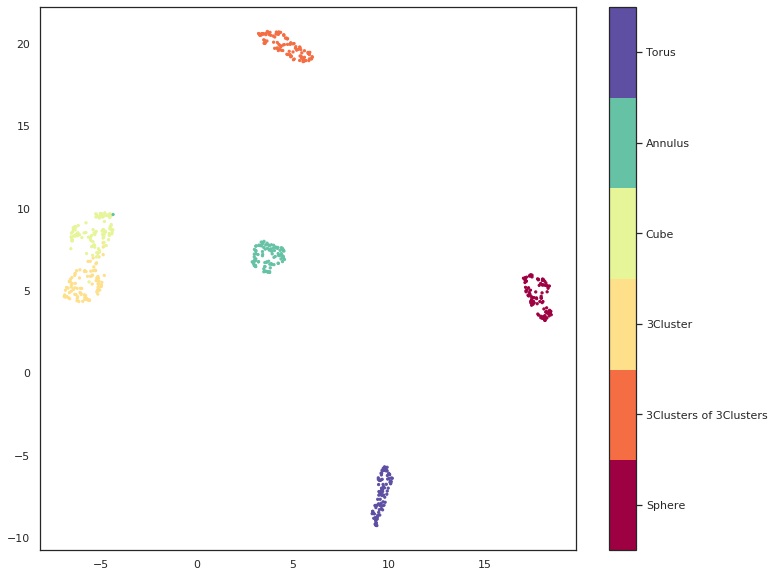

In [29]:
plt.figure(figsize=(12,10))
labels = np.concatenate([i * np.ones(100) for i in range(6)])
plt.scatter(*mapper.embedding_.T, s=5, c=labels, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(manifoldData.trainingLabel.unique()[::-1])

We see that this had done a good job of seperating the classes. Interestingly it does worse at separating the classes than the image we had earlier treating the Gaussians as categoricals -- this is because while the diagrams for the cube and the 3-clusters are separable, they are actually quite close to each other (we were looking only at $H_1$, and neither has an interesting structure there -- ultimately the diagrams differ more on the distance scales involved, so they are actually somewhat close in Wasserstein distance. That is - -the real question is:

#### How well does this correlate with the true Wasserstein distance?

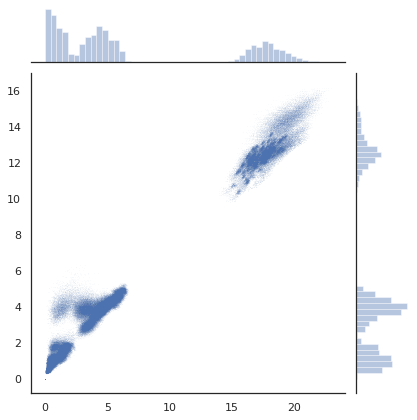

In [30]:
sns.jointplot(all_pairs_distances_a.flatten(), wass_all_pairs_dist.flatten(), joint_kws={'s':0.01, 'alpha':0.1})

In [31]:
scipy.stats.pearsonr(all_pairs_distances_a.flatten(), wass_all_pairs_dist.flatten())

(0.9916782125287703, 0.0)

For only using 10 components (and thus a 10-dimensional vectorization) this looks pretty darn good! 

# Now we are just going to import everything so we can check performance with a handful of various parameter choices

In [32]:
from pervect import PersistenceVectorizer

In [33]:
n_features = [diagram.shape[0] for diagram in JustDgms_death]
print(np.min(n_features))
print(np.average(n_features))
print(np.max(n_features))

36
67.07166666666667
98


We'll go up to 50 bins which, given the above, is overkill but we should get a sense of what can happen when you have more Gaussians than topological features in some of the diagrams (a case where it's unlikely you should want to approximate a diagram with more features than the actual diagram has but it's worth looking at and thinking about). 

In [34]:
pervec50_d = PersistenceVectorizer(n_components=50, y_axis='death').fit(JustDgms_death)
pervec20_d = PersistenceVectorizer(n_components=20, y_axis='death').fit(JustDgms_death)
pervec10_d = PersistenceVectorizer(n_components=10, y_axis='death').fit(JustDgms_death)
pervec5_d = PersistenceVectorizer(n_components=5, y_axis='death').fit(JustDgms_death)
pervec2_d = PersistenceVectorizer(n_components=2, y_axis='death').fit(JustDgms_death)

In [35]:
pervec50_l = PersistenceVectorizer(n_components=50, y_axis='lifetime').fit(JustDgms_lifetime)
pervec20_l = PersistenceVectorizer(n_components=20, y_axis='lifetime').fit(JustDgms_lifetime)
pervec10_l = PersistenceVectorizer(n_components=10, y_axis='lifetime').fit(JustDgms_lifetime)
pervec5_l = PersistenceVectorizer(n_components=5, y_axis='lifetime').fit(JustDgms_lifetime)
pervec2_l = PersistenceVectorizer(n_components=2, y_axis='lifetime').fit(JustDgms_lifetime)

Check some timings:

In [36]:
%%time
all_dist50_d = pervec50_d.pairwise_p_wasserstein_distance(1, JustDgms_death)

CPU times: user 1min 17s, sys: 85.2 ms, total: 1min 17s
Wall time: 1min 16s


In [37]:
%%time
all_dist20_d = pervec20_d.pairwise_p_wasserstein_distance(1, JustDgms_death)

CPU times: user 28.1 s, sys: 117 ms, total: 28.2 s
Wall time: 28.2 s


In [38]:
%%time
all_dist10_d = pervec10_d.pairwise_p_wasserstein_distance(1, JustDgms_death)

CPU times: user 18.3 s, sys: 141 ms, total: 18.4 s
Wall time: 18.4 s


In [39]:
%%time
all_dist5_d = pervec5_d.pairwise_p_wasserstein_distance(1, JustDgms_death)

CPU times: user 15.1 s, sys: 109 ms, total: 15.2 s
Wall time: 15.2 s


In [40]:
%%time
all_dist2_d = pervec2_d.pairwise_p_wasserstein_distance(1, JustDgms_death)

CPU times: user 14.4 s, sys: 82.1 ms, total: 14.4 s
Wall time: 14.4 s


Lets just do all the rest

In [41]:
%%time
all_dist50_l = pervec50_l.pairwise_p_wasserstein_distance(2, JustDgms_lifetime)
all_dist20_l = pervec20_l.pairwise_p_wasserstein_distance(2, JustDgms_lifetime)
all_dist10_l = pervec10_l.pairwise_p_wasserstein_distance(2, JustDgms_lifetime)
all_dist5_l = pervec5_l.pairwise_p_wasserstein_distance(2, JustDgms_lifetime)
all_dist2_l = pervec2_l.pairwise_p_wasserstein_distance(2, JustDgms_lifetime)

CPU times: user 2min 39s, sys: 470 ms, total: 2min 39s
Wall time: 2min 39s


#### Let's check the correlation between the approximation and the correct answer to see how well we're doing

In [42]:
print(scipy.stats.pearsonr(all_dist2_d.flatten(), wass_all_pairs_dist.flatten()))
print(scipy.stats.pearsonr(all_dist5_d.flatten(), wass_all_pairs_dist.flatten()))
print(scipy.stats.pearsonr(all_dist10_d.flatten(), wass_all_pairs_dist.flatten()))
print(scipy.stats.pearsonr(all_dist20_d.flatten(), wass_all_pairs_dist.flatten()))
print(scipy.stats.pearsonr(all_dist50_d.flatten(), wass_all_pairs_dist.flatten()))

(0.9427537428558006, 0.0)
(0.9750705413575094, 0.0)
(0.9928372769719671, 0.0)
(0.9933494276075333, 0.0)
(0.9948436353067229, 0.0)


In [43]:
print(scipy.stats.pearsonr(all_dist2_l.flatten(), wass2_all_pairs_dist.flatten()))
print(scipy.stats.pearsonr(all_dist5_l.flatten(), wass2_all_pairs_dist.flatten()))
print(scipy.stats.pearsonr(all_dist10_l.flatten(), wass2_all_pairs_dist.flatten()))
print(scipy.stats.pearsonr(all_dist20_l.flatten(), wass2_all_pairs_dist.flatten()))
print(scipy.stats.pearsonr(all_dist50_l.flatten(), wass2_all_pairs_dist.flatten()))

(0.904331707687738, 0.0)
(0.9574382946889632, 0.0)
(0.9776873096760041, 0.0)
(0.9940994053468857, 0.0)
(0.9960356249228381, 0.0)


Pretty darn good but as one would expect, the convergence starts to wobble when the number of bins gets high (like higher than the number of features in some diagrams) which, at that point, why would you bother approximating it and not just compute it directly?  It will be obviously slower once you have more bins than features in a given diagram. Don't get me wrong - despite the wobble, I expect it to converge to 1, just not monotonically I guess. 

Perhaps there is a better way to fit the gmm to get this to work out better or another idea to tweak this a bit further to get convergence to be monotonic.  I personally don't think it's crazy important but it's a little annoying.  One thing I tried was to fit the gmm by kmeans clustering all the data and then fit each gaussian centered at the kmeans centroid to the data in that cluster.  You get smaller, less wild shaped Gaussians which may converge better at the expense of fitting a bit worse (since this isn't the MLE).  Feels a little like a hack to do that though and it's not clear it's worth it. 

### Lets just plot the 2 component  vectorization directly just for fun!

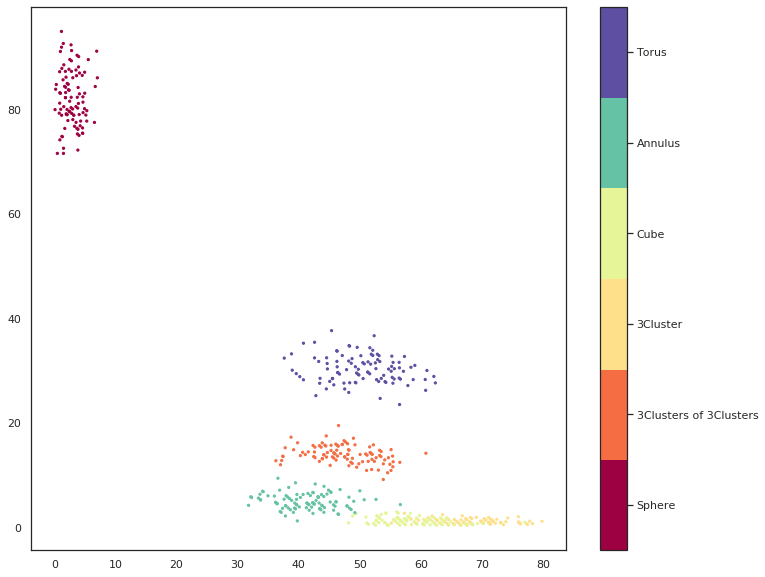

In [44]:
plt.figure(figsize=(12,10))
labels = np.concatenate([i * np.ones(100) for i in range(6)])
plt.scatter(*pervec2_d.transform(JustDgms_death).T, s=5, c=labels, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(manifoldData.trainingLabel.unique()[::-1])

Even something this simple does a good job of separating the classes!

# Viewing diagrams as heatmaps of the GMM

Our vectorization are the weights of a gmm (rescaled appropriately) so we can take a heat map of the correspoonding mixture of gaussians and see how well this visually approximates the actual diagram. 

In [45]:
x_max = max([j[:,0].max() for j in JustDgms_lifetime])*1.05
y_max = max([j[:,1].max() for j in JustDgms_lifetime])*1.05

In [46]:
def diagram_to_heatmap(diag, gmm, n_cells=300):
    xs = np.arange(0,x_max, x_max/n_cells)
    ys = np.arange(0,y_max, y_max/n_cells)
    a, b = np.meshgrid(xs,ys)
    mat = gmm.score_samples(np.column_stack((a.flatten(),b.flatten()))).reshape((n_cells,n_cells))
    # the score is the log likelihood so we have to fix that and flip the y_axis 
    #    and we rescale with log(1+x) for visualization ease 
    return np.flip(np.log1p(np.exp(mat)), axis = 0)

We'll set the model to be the one with 20 bins and check how this compares to a diagram of each type  

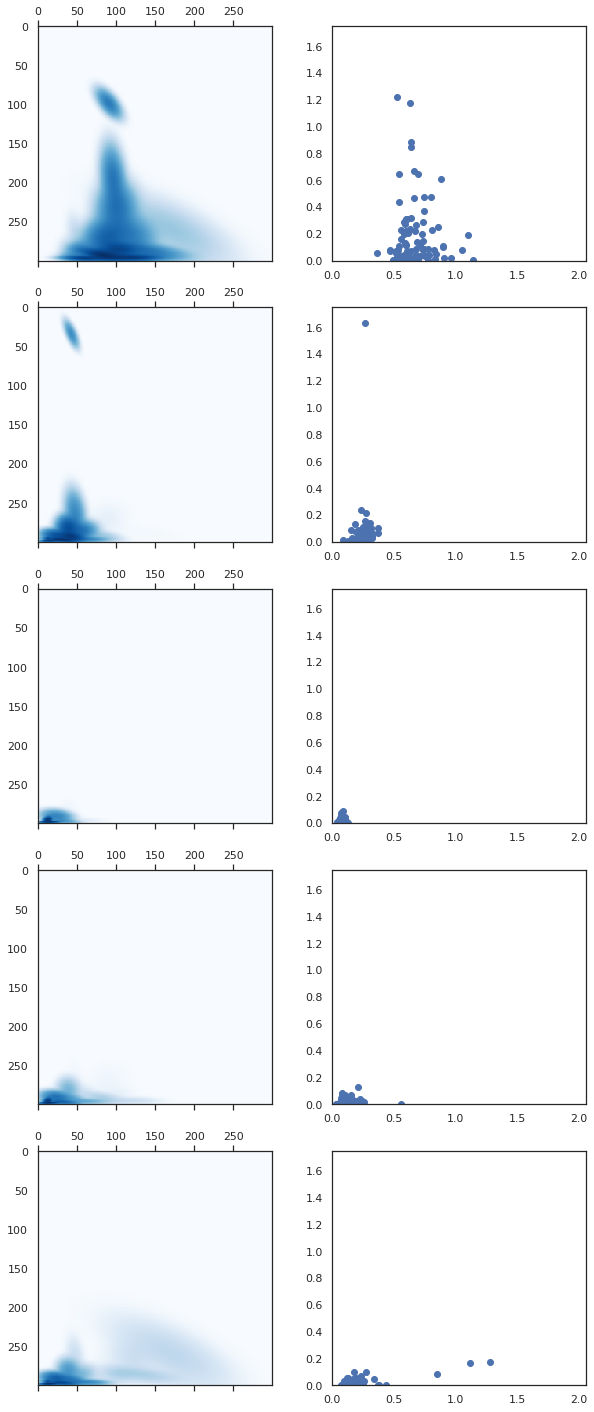

In [47]:
model = pervec20_l

# pick a collection of diagrams
fig_ind = np.array([0,100,200,300,400,500])+42

fig, axes = plt.subplots(5,2, figsize = (10,25))
for i in range(5) :
    diag_number = fig_ind[i]
    my_gmm = model.mixture_model_
    my_gmm.weights_ = model.transform([JustDgms_lifetime[diag_number]])+1e-80 # The gmm evaluation hates zero weights
    hmap = diagram_to_heatmap(JustDgms_lifetime[diag_number], my_gmm)
    axes[i,0].matshow(hmap, cmap="Blues")
    axes[i,1].scatter(*JustDgms_lifetime[diag_number].T)
    axes[i,1].axis([0,x_max,0,y_max])
 

### I'd say that this is pretty darn good for only using 20 total Gaussians.

# Optional extras for those with a lot of compute

Obviously distances are converging to be closely correlated with true Wasserstein distance; but how close can we push that? While having a large number of components is not really desireable since it will actually make the distance computation take *longer* than the full Wasserstein distance computation, it may be useful to see how closely we converge toward true Wasserstein distance as the number of components significantly increases. To demonstrate this let's use 500 components.   

In [48]:
pervec500_l = PersistenceVectorizer(n_components=500, y_axis='lifetime').fit(JustDgms_lifetime)

We can compute the all pairs distances as before:

In [49]:
%%time
all_dist500_l = pervec500_l.pairwise_p_wasserstein_distance(2, JustDgms_lifetime)

CPU times: user 3h 34min 52s, sys: 18min 57s, total: 3h 53min 50s
Wall time: 1h 4min 37s


How close is this result correlated with true Wasserstein?

In [50]:
print(scipy.stats.pearsonr(all_dist500_l.flatten(), wass2_all_pairs_dist.flatten()))

(0.9996721283078908, 0.0)


That's a very strong correlation, and indeed is likely getting close to as good as one might expect given floating point precision and optimizer accuracy for the actual earth mover distance computations. We can see what is going on visually with the joint plot as before:

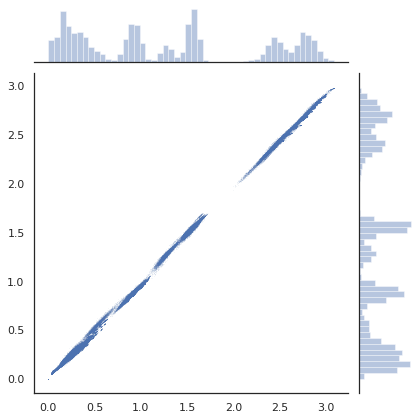

In [51]:
sns.jointplot(all_dist500_l.flatten(), wass2_all_pairs_dist.flatten(), joint_kws={'s':0.01, 'alpha':0.1})

That looks like an excellent match! Using 500 components we are getting extremely close to very accurate computations of Wasserstein distance. We can take this further and actually complete the regression to look at the slope and intercept:

In [52]:
scipy.stats.linregress(all_dist500_l.flatten(), wass2_all_pairs_dist.flatten())

LinregressResult(slope=0.973475946155998, intercept=0.00916271862767526, rvalue=0.9996721283078895, pvalue=0.0, stderr=4.1557456104861415e-05)

A slope very close to one, and an intercept very close to zero -- as we would expect. Let's plot the residuals to see where and how we are getting things wrong.

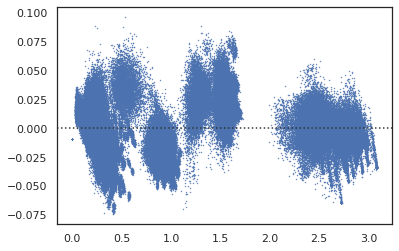

In [53]:
sns.residplot(all_dist500_l.flatten(), wass2_all_pairs_dist.flatten(), scatter_kws={"s":0.1})

Notably most of the residuals are roughly normally distributed about the regression line. At about the 1.5 range the PerVect approach has a slight tendency to underestimate distances, and there are some notable outliers in a few places. Still, and excellent result.

So, finally, how well do we reconstruct the diagrams?

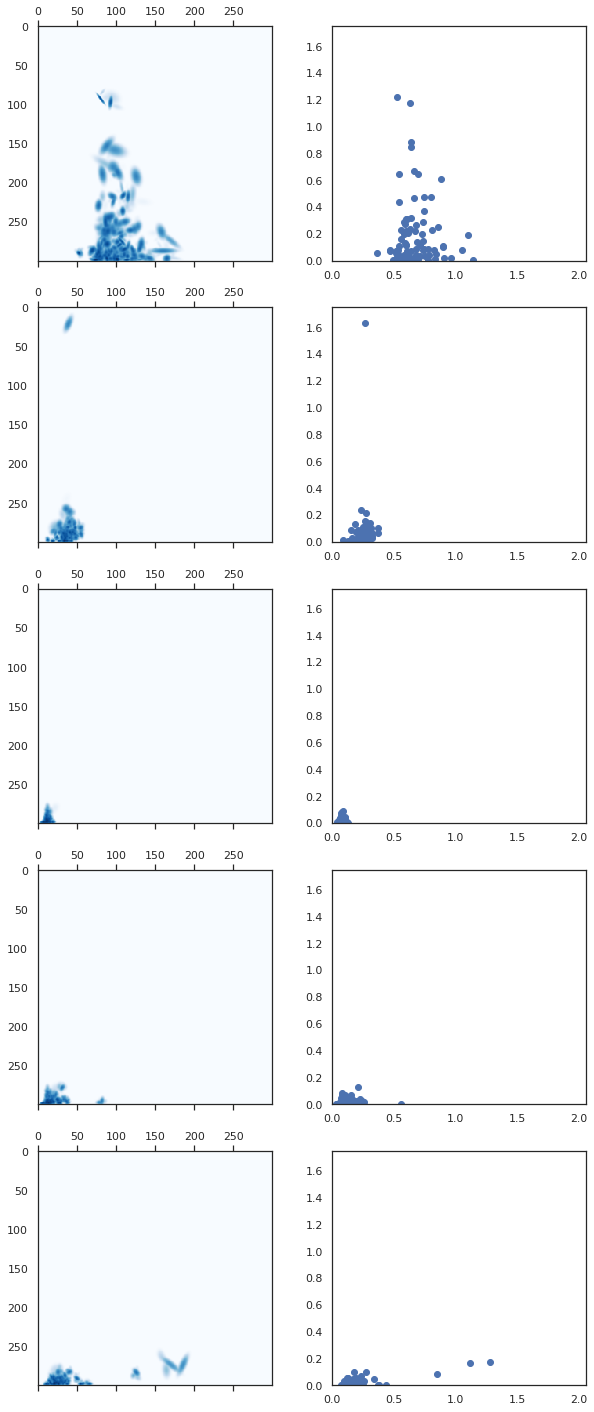

In [54]:
model = pervec500_l

# pick a collection of diagrams
fig_ind = np.array([0,100,200,300,400,500])+42

fig, axes = plt.subplots(5,2, figsize = (10,25))
for i in range(5) :
    diag_number = fig_ind[i]
    my_gmm = model.mixture_model_
    my_gmm.weights_ = model.transform([JustDgms_lifetime[diag_number]])+1e-80 # The gmm evaluation hates zero weights
    hmap = diagram_to_heatmap(JustDgms_lifetime[diag_number], my_gmm)
    axes[i,0].matshow(hmap, cmap="Blues")
    axes[i,1].scatter(*JustDgms_lifetime[diag_number].T)
    axes[i,1].axis([0,x_max,0,y_max])
 

Very well indeed.